In [2]:
import pandas as pd
from tqdm import tqdm
import os
import openai
from glob import glob
import pickle

In [3]:
cous = pd.read_pickle('../data/processed/counts_of_unique_subjects.pickle')

In [4]:
cous.sum(axis=1).sort_values(ascending=False).iloc[:30]

pld
www.coursera.org               7520.0
www.edx.org                    7407.0
studylib.net                   5646.0
www.diziler.com                4683.0
www.physicsforums.com          4677.0
ja.coursera.org                3851.0
ru.coursera.org                3784.0
pt.coursera.org                3601.0
fr.coursera.org                3375.0
zh.coursera.org                3353.0
es.coursera.org                3336.0
de.coursera.org                3162.0
ko.coursera.org                3053.0
codegalaxy.io                  3026.0
zh-tw.coursera.org             3023.0
www.goconqr.com                2471.0
www.lynda.com                  2017.0
www.verboeducacional.com.br    1526.0
www.taskutark.ee               1143.0
drops.dagstuhl.de              1135.0
www.haberankara.com            1113.0
www.lumoslearning.com          1013.0
mille-sorties.com               895.0
quiwego.com                     848.0
redooc.com                      832.0
studylibpl.com                  744.0
www.habe

In [15]:
from glob import glob

top_ed_domain_data_files = glob('../data/processed/pld_data/*.csv')

In [16]:
top_ed_data = [(f, pd.read_csv(f, index_col=0)) for f in top_ed_domain_data_files]

In [18]:
def get_name_year(path):
    filename = path.split('/')[-1]
    name = filename.replace('.csv', '')
    pld, year = re.findall('([a-z_]+)_([0-9]+)', name)[0]
    year = int(year)
    pld = pld.replace('_', '.')
    return pld, year

# [(get_name_year(f), df.shape[0]) for (f, df) in top_ed_data]

In [19]:
def summary_stats(filepath, df):
    pld, year = get_name_year(filepath)
    s_count = df.s.nunique()
    p_count = df.p.nunique()
    ps_per_s_count = df.groupby('s').p.nunique().mean()
    return pd.Series({
        'pld': pld,
        'year': year,
        'ps_per_s_count': ps_per_s_count,
        's_count': s_count,
        'p_count': p_count
    })

# pd.DataFrame([summary_stats(f, df) for (f, df) in top_ed_data]).groupby('pld').s_count.apply(list)

In [25]:
def get_title_desc(df):
    o_str_exists = (df.o.notna()) & (df.o.str.strip().str.len() > 0)
    descriptions = df[(df.p.str.contains('description')) & o_str_exists].o
    title = df[df.p.str.contains('name') & o_str_exists].o
    if (descriptions.shape[0] > 0) and (title.shape[0] > 0):
        return pd.Series({'desc': descriptions.iloc[0],
                          'title': title.iloc[0],
                          'url': df.s.iloc[0]})
    else:
        return pd.Series({'desc': None, 'title': None, 'url': df.s.iloc[0]})


def prompt_template(title, description):
    return f"""The following text is the title and description of a course. Give me a list of learning objectives of the course, the subject the course belogs to and what level of student it is appropriate for.

    Text: \"\"\"Title: {title} Description: {description}\"\"\"

    Learning objectives, subject and student level:"""
    
prompts = []
for ed_data in tqdm(top_ed_data):
    domain, year = get_name_year(ed_data[0])
    if ed_data[1].shape[0] > 0:
        title_descs = ed_data[1].groupby('s').apply(get_title_desc)
        for _, row in title_descs.iterrows():
            prompts.append({'domain': domain, 'year': year, 'title' : row.title, 
                            'desc': row.desc, 'url': row.url, 
                            'prompt': prompt_template(row.title, row.desc)})
    
prompts = pd.DataFrame(prompts).drop_duplicates(subset=['prompt'])
prompts = prompts[prompts.desc.notna() & prompts.title.notna()]
from hashlib import md5
prompts['hashed_prompt'] = prompts.prompt.apply(lambda p: str(md5(p.encode('utf-8')).hexdigest()))

100%|█████████████████████████████████| 33/33 [01:25<00:00,  2.60s/it]


In [28]:
sample_prompts.shape, prompts.shape

((9722, 6), (29460, 7))

In [37]:
sample_prompts = sample_prompts.join(prompts[['hashed_prompt', 'url']].set_index('hashed_prompt'), 
                                     on='hashed_prompt')

In [ ]:
sample_prompts = prompts.groupby('domain').sample(frac=0.33)

In [ ]:
sample_prompts.head(2)

In [ ]:
# !mkdir ../data/gpt_results

In [ ]:
gpt_model='text-davinci-003'

In [ ]:
gpt_temperature=0.1

In [ ]:
gpt_max_length = 256

In [39]:
# sample_prompts.to_pickle('../data/sample_prompts.pickle')

In [40]:
sample_prompts = pd.read_pickle('../data/sample_prompts.pickle')

In [ ]:
def save_completion_to_file_if_not_exists(filename, prompt):
    if not os.path.exists(filename):
        completion = generate_text(prompt)
        with open(filename, 'w') as f:
            if completion is not None:
                f.write(completion)
            else:
                f.write("NO_COMPLETION")
            print(f"File '{filename}' created and contents saved successfully.")
    else:
        print(f"File '{filename}' already exists. Contents not saved.")
        
openai.api_key = os.environ["OPENAI_API_KEY"]  # Set your API key as an environment variable

def generate_text(prompt, model=gpt_model, temperature=gpt_temperature, max_tokens=gpt_max_length):
    try:
        response = openai.Completion.create(
            engine=model,
            prompt=prompt,
            max_tokens=max_tokens,
            temperature=temperature
        )

        if response.choices:
            return response.choices[0].text.strip()
        else:
            return "NO_COMPLETION"

    except openai.error.InvalidRequestError as e:
        print(f"Invalid request error: {e}")
        return "ERROR: InvalidRequest"

    except openai.error.AuthenticationError as e:
        print(f"Authentication error: {e}")
        return "ERROR: Authentication"

    except openai.error.APIConnectionError as e:
        print(f"API connection error: {e}")
        return "ERROR: APIConneection"

    except openai.error.OpenAIError as e:
        print(f"OpenAI error: {e}")
        return "ERROR: OpenAI"


# sample_prompts.shape
running_set = sample_prompts
# running_set = sample_prompts[sample_prompts.hashed_prompt.isin(completed)]
for _, prompt in tqdm(running_set.iterrows(), total=running_set.shape[0]):
    save_completion_to_file_if_not_exists(f'../data/gpt_results/{prompt.hashed_prompt}.completion_temp_01', 
                               prompt.prompt)

In [3]:
completed_07 = glob('../data/gpt_results/*.completion_temp_07')
completed_07 = [c.split('/')[-1].split('.')[0] for c in completed_07]

In [4]:
completed_01 = glob('../data/gpt_results/*.completion_temp_01')
completed_01 = [c.split('/')[-1].split('.')[0] for c in completed_01]

In [5]:
len(completed_07), len(completed_01)

(32, 9722)

In [6]:
import re

overall_pattern_1 = re.compile('^Learning [Oo]bjectives:(.*)Subject: (.*)Student [Ll]evel: (.*)', flags=re.DOTALL)
overall_pattern_2 = re.compile('^(1\..*)Subject: (.*)Student [Ll]evel: (.*)', flags=re.DOTALL)
split_los_pattern = re.compile('[0-9]+\.', re.DOTALL)

def parse_completion(c):
    segments = overall_pattern_1.findall(c)
    if len(segments) == 0:
        segments = overall_pattern_2.findall(c)
    if len(segments) > 0:
        learning_objectives = [lo.strip() 
                               for lo 
                               in re.split(split_los_pattern, segments[0][0].strip()) 
                               if lo.strip()]
        subject = segments[0][1].strip()
        level = segments[0][2].strip()
        return learning_objectives, subject, level
    else:
        return None
        

In [ ]:
with open('../data/gpt_results/e361269fedf9f45642da1b0497fcb098.completion_temp_07') as f:
    completion = f.read()
print(completion)
parse_completion(completion)

In [14]:
sample_prompts

,domain,year,title,desc,prompt,hashed_prompt
13455,es.coursera.org,2021,Business English: Final Project,Ofrecido por Universidad del Estado de Arizona...,The following text is the title and descriptio...,5027a9f6729e9e622232ad2c5743f5c0
14032,es.coursera.org,2021,Managing Security in Google Cloud,Ofrecido por Google Cloud. This self-paced tra...,The following text is the title and descriptio...,2d7f967dff41b3da101f10f9535fa28f
14614,es.coursera.org,2021,Evolution: A Course for Educators,Ofrecido por Museo Americano de Historia Natur...,The following text is the title and descriptio...,c02bedb7edff8dae4165cfac665dae09
13487,es.coursera.org,2021,Estrategia Empresarial,Ofrecido por Universidad Austral. El curso te ...,The following text is the title and descriptio...,a325ec8c6b45967bcf4e316a536f2c39
14715,es.coursera.org,2021,Valuation for Startups Using Multiple Approach,Ofrecido por Universidad Yonsei. In addition t...,The following text is the title and descriptio...,00fa8b30906b0453948e3e44bfccd7bd
...,...,...,...,...,...,...
17900,zh.coursera.org,2021,Core Concepts of Accounting – Numbers and People,"Whenever the word “accounting” is pronounced, ...",The following text is the title and descriptio...,80559913dd52690e7183f1dfafbd6eab
18738,zh.coursera.org,2021,Practical Reinforcement Learning,由 俄罗斯国家研究型高等经济大学 提供。Welcome to the Reinforceme...,The following text is the title and descriptio...,e2bd67425a20478ec24d74da6476b6cb
18578,zh.coursera.org,2021,Machine Learning: Classification,由 华盛顿大学 提供。Case Studies: Analyzing Sentiment &...,The following text is the title and descriptio...,e7e9fd03c39c88c788aac3eaf0e705e7
49563,zh.coursera.org,2020,Mastering Data Analysis in Excel,"In business, data and algorithms create econom...",The following text is the title and descriptio...,1cb975d4697375fc6e07e35aaab1a685


In [42]:
completions_df_data = []

for c in completed_01:
    out = {}
    with open(f'../data/gpt_results/{c}.completion_temp_01') as f:
        completion = f.read()
    if completion.startswith('ERROR'):
        continue
    prompt = sample_prompts[sample_prompts.hashed_prompt == c]
    out["ID"] = c
    out["Domain"] = prompt.domain.iloc[0]
    out["Year"] = prompt.year.iloc[0]
    out["Title"] = prompt.title.iloc[0]
    out["Description"] = prompt.desc.iloc[0]
    out["URL"] = prompt.url.iloc[0]
    parsed_completion = parse_completion(completion)
    if parsed_completion:
        los, subject, level = parsed_completion
        out['LearningObjectives'] = los
        out["Subject"] = subject
        out["Level"] = level
        completions_df_data.append(out)
    else:
        print("UNPARSABLE COMPLETION:", completion)

UNPARSABLE COMPLETION: Learning Objectives:
1. Изучить принципы и методы ИТ-кризисологии.
2. Разработать план модернизации системы автоматизации управления воздушным движением.
3. Оценить потенциальные риски и преимущества модернизации.
4. Применить принципы ИТ-кризис
UNPARSABLE COMPLETION: Learning Objectives:
1. Изучить основы финансового анализа и принятия решений по финансированию бизнеса.
2. Разработать навыки анализа и принятия решений с позиции кредитора и инвестора.
3. Применить практические знания и навыки для анализа финансовых
UNPARSABLE COMPLETION: Learning Objectives:
1. Изучить основные понятия языка Котлин.
2. Научиться писать программы на языке Котлин.
3. Научиться использовать библиотеки и фреймворки для разработки приложений на языке Котлин.
4. Научиться отлаживать и оптимизировать програм
UNPARSABLE COMPLETION: Learning Objectives:
1. Изучить основные понятия и принципы теории вероятностей.
2. Разработать навыки применения теории вероятностей для решения математическ

In [46]:
completions_df = pd.DataFrame(completions_df_data)

In [47]:
completions_df.shape

(2974, 9)

In [49]:
completions_df.head(2)

,ID,Domain,Year,Title,Description,URL,LearningObjectives,Subject,Level
0,9a290b1c524835bef4b81cb0fb93fd0f,ja.coursera.org,2020,Introducción a la programación en Python I: Ap...,Decía Steve Jobs que “todo el mundo debería ap...,https://ja.coursera.org/learn/aprendiendo-prog...,[Comprender los conceptos básicos de programac...,Programación en Python,Principiantes
1,4d0285aa87993939346887d78ff28fa4,fr.coursera.org,2020,Business English: Meetings,This course will teach you vocabulary and skil...,https://fr.coursera.org/learn/business-english...,[Understand the purpose of meetings and the ro...,Business English,Beginner to Intermediate


In [51]:
props = dict()
for url in tqdm(completions_df.URL):
    for filename, ed_data in top_ed_data:
        domain, year = get_name_year(filename)
        if ed_data.shape[0] > 0:
            props_for_url = ed_data[ed_data.s == url]
            if props_for_url.shape[0] > 0:
                props[url] = props_for_url
                break


100%|█████████████████████████████| 2974/2974 [00:35<00:00, 83.16it/s]


In [54]:
language = dict()
for url in props:
    ps = props[url]
    language[url] = None
    languages = ps[ps.p == 'http://schema.org/inLanguage']
    if languages.shape[0] > 0:
        language[url] = languages.o.iloc[0]

In [63]:
completions_df['language'] = completions_df.URL.apply(language.__getitem__)

In [64]:
completions_df.Domain.value_counts()

ja.coursera.org     1195
fr.coursera.org      863
es.coursera.org      707
www.coursera.org      79
www.edx.org           41
ru.coursera.org       26
pt.coursera.org       23
www.diziler.com       22
zh.coursera.org       18
Name: Domain, dtype: int64

In [68]:
completions_df[completions_df.language == 'en'].Subject.value_counts().iloc[:20]

Computer Science           69
Cloud Computing            52
Data Science               43
Finance                    38
Machine Learning           34
Statistics                 30
Business                   29
Artificial Intelligence    25
Economics                  25
Public Health              24
Education                  24
Philosophy                 22
Mathematics                21
History                    21
Leadership                 20
Cybersecurity              20
Psychology                 16
Data Analysis              16
Physics                    15
Python Programming         14
Name: Subject, dtype: int64

In [79]:
los = completions_df[completions_df.language == 'en'].LearningObjectives.apply(pd.Series).unstack().reset_index(drop=True)
los.value_counts().iloc[:20]

Analyze financial statements and reports.                         11
Develop skills in data analysis and visualization.                 8
Develop problem-solving skills.                                    7
Learn how to register for the course for free.                     7
Develop skills in data analysis and interpretation.                6
Understand the fundamentals of data science.                       6
Analyze data to identify trends and patterns.                      6
Understand the fundamentals of financial accounting.               5
Develop basic conversational skills in Mandarin Chinese.           5
Develop skills in data visualization.                              5
Develop an understanding of the accounting cycle.                  5
Understand the fundamentals of machine learning                    5
Understand the fundamentals of machine learning.                   5
Develop an understanding of Chinese culture and customs.           5
Understand the fundamentals of Pyt

In [6]:
years = [2019.]

In [38]:
import pickle
p_counts = dict()
for year in years:
    with open(f'../data/p_counts_{year}.pickle', 'rb') as f:
        p_counts[year] = pickle.load(f)
        p_counts[year].columns = p_counts[year].columns.droplevel(0)

In [39]:
p_counts[2019].shape

(216656, 296)

In [13]:
education_ps = [

'http://schema.org/courseCode',

'http://schema.org/coursePrerequisite', 

'http://schema.org/courseSku',

'http://schema.org/educationalCredentialAwarded',

'http://schema.org/educationalOutcome',

'http://schema.org/hasCourseInstance', 

'http://schema.org/subjectOfStudy',

"http://schema.org/alignmentType",

"http://schema.org/educationalFramework",

"http://schema.org/educationalAlignment",

"http://schema.org/learningResourceType",

"http://schema.org/interactivityType",

"http://schema.org/educationalUse",

"http://schema.org/educationalLevel",

]

In [19]:
col_list = set(education_ps).intersection(p_counts[2019].columns.get_level_values(1))


In [22]:
p_counts[2019].columns = p_counts[2019].columns.droplevel(0)

In [29]:
total = p_counts[2019][col_list].shape[0]
has_ed = p_counts[2019][col_list].dropna(how='all')
has_ed.shape[0] / total

/tmp/ipykernel_1539759/310286761.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total = p_counts[2019][col_list].shape[0]
/tmp/ipykernel_1539759/310286761.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  has_ed = p_counts[2019][col_list].dropna(how='all')


0.033029318366442656

In [35]:
has_ed.index.str.extract('^.*:\/\/(.*?)\/.*$')[0].value_counts().iloc[:10]

www.edx.org          1576
codegalaxy.io        1241
studylib.net          932
studylibnl.com        262
www.fisicalab.com     259
studylibpl.com        251
studylibpt.com        204
studylibtr.com        197
studylibde.com        197
studylib.ru           169
Name: 0, dtype: int64

In [42]:
def get_domains_with_ed_props(df):
    col_list = set(education_ps).intersection(df.columns)
    has_ed = df[col_list].dropna(how='all')
    top_domains = has_ed.index.str.extract('^.*:\/\/(.*?)\/.*$')[0].value_counts().iloc[:10]
    all_domains = df.index.str.extract('^.*:\/\/(.*?)\/.*$')[0].value_counts().iloc[:10]
    return top_domains, all_domains
    

In [44]:
for year in years:
    top_ed_domains, all_domains = get_domains_with_ed_props(p_counts[year])
    print(year, "--->")
    for d in top_ed_domains.iloc[:10]:
        print(d)
    print(all_domains.shape[0] / top_ed_domains.shape[0])

/tmp/ipykernel_1539759/1610503958.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  has_ed = df[col_list].dropna(how='all')


2019 --->
1576
1241
932
262
259
251
204
197
197
169
1.0


In [4]:
# p_counts = []
# for url in props:
#     ps = props[url]
#     ps = ps.p.value_counts().to_dict()
#     ps['url'] = url
#     lower_ps = dict()
#     for k in ps:
#         lower_ps[k.lower()] = ps[k]
#     p_counts.append(lower_ps)
# p_counts_df = pd.DataFrame(p_counts)

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_plot(data, n_components=2):
    # Standardize the data
    data_std = (data - data.mean()) / data.std()

    # Create a PCA object with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to the data
    pca.fit(data_std)

    # Transform the data using the PCA model
    data_pca = pca.transform(data_std)

    # Plot the transformed data
    fig, ax = plt.subplots()
    ax.scatter(data_pca[:, 0], data_pca[:, 1])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA Plot")

    plt.show()


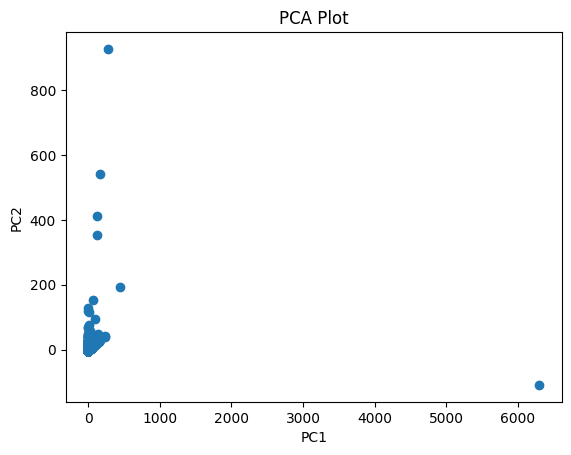

In [5]:
pca_plot(p_counts[2020].sample(frac=0.1).fillna(0).values)

In [132]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def pca_plot_clusters(data, n_components=2, n_clusters=2):
    # Standardize the data
    data_std = (data - data.mean()) / data.std()

    # Create a PCA object with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to the data
    pca.fit(data_std)

    # Transform the data using the PCA model
    data_pca = pca.transform(data_std)

    # Cluster the transformed data using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(data_pca)
    
    ls = labels.copy()

    # Plot the transformed data with colors based on the cluster labels
    fig, ax = plt.subplots()
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='rainbow')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA Plot with Clusters")

    # Add a legend
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles, labels, loc="upper right")

    plt.show()
    return ls


/home/rsebastian/.anaconda3/envs/lwva/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


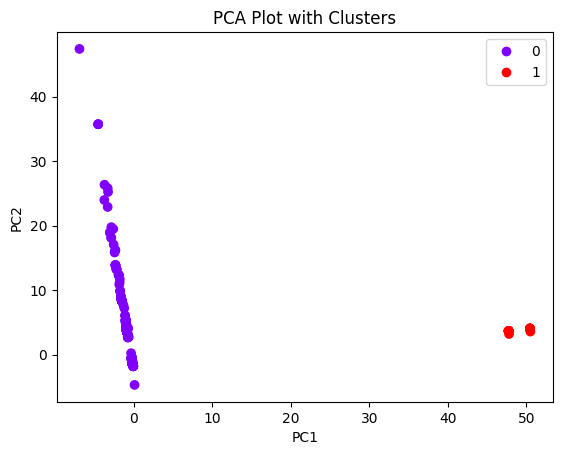

In [135]:
cluster_labels = pca_plot_clusters(p_counts_df.fillna(0).drop(columns='url'), 
                                   n_components=2, n_clusters=2)
cluster_labels = pd.DataFrame(zip(p_counts_df.url.values, cluster_labels), columns=["url", "cluster"])

In [124]:
cluster_labels.cluster.value_counts()

0    2306
2     558
1      22
Name: cluster, dtype: int64

In [125]:
cluster_labels.groupby('cluster').apply(lambda df: df.url.apply(lambda s: s.split('//')[1].split('/')[0]).unique())

cluster
0    [fr.coursera.org, ja.coursera.org, es.coursera...
1                                    [www.diziler.com]
2    [ja.coursera.org, fr.coursera.org, es.coursera...
dtype: object

In [111]:
cluster_labels.shape

(2886,)

In [59]:
pd.Series([i for i in language.values() if i]).value_counts()

en       2050
es        295
ru        197
fr         75
pt-BR      73
zh-CN      40
ar         25
en-us      25
ja         23
tr-TR      22
zh-TW      17
de          9
id          5
he          3
es-mx       3
pt          2
it          2
en-au       2
sv          2
tr          2
es-gt       2
uk          2
en-ca       1
es-co       1
de-de       1
es-es       1
es-ar       1
hi          1
en-in       1
fr-fr       1
en-gb       1
dtype: int64

In [103]:
# How is license being used

In [ ]:
# Ask teachers before they start using it for stuff you want to automatically detect.
# I think you're currently exploring / something else , are you ?

In [ ]:
another_running_set.hashed_prompt

In [ ]:
prompt_texts = set()
prompt_lengths = []

for _, prompt in sample_prompts.iterrows():
    prompt_text = prompt.prompt
    prompt_texts.add(prompt_text)
    prompt_lengths.append(len(prompt_text.split(' ')))

len(set(prompt_texts)), sum(prompt_lengths)

In [ ]:
prompt_texts

In [ ]:
17 / 50

In [ ]:
title_descs_sample.title.iloc[0]

In [ ]:
[(f, df[df.p.str.contains('description')].o.value_counts()) 
 for (f, df) 
 in top_ed_data]